### 2. Hyperparameter Tuning using the training data

Separately for each country, food security outcome, category measure, and the two ML models

The main tuning methodology we use is similar to a coordinate descent, which is to tune one parameter while holding the other ones constant. The advantage of this method is no need to calculate the gradient and saves the time for a full grid search. Instead of going through all the parameters, we go line search on parameters that have monotone or almost monotone effects on the model performance. The model performance is evaluated as the cross-validated AUROC and we also take into account the standard error of the performance among the different folds.

In [1]:
# Set up Notebook
%matplotlib inline

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings('ignore')


# Standard imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib import cm

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from scipy.stats import pearsonr

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import average_precision_score
    
from sklearn import metrics
from sklearn.metrics import confusion_matrix,explained_variance_score
from sklearn.metrics import mean_absolute_error,mean_squared_error,median_absolute_error,r2_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import roc_curve,auc,precision_recall_curve

from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler 
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN

from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression


In [2]:
mw_village = pd.read_csv('data/clean/dataset/mw_village.csv')
tz_village = pd.read_csv('data/clean/dataset/tz_village.csv')
ug_village = pd.read_csv('data/clean/dataset/ug_village.csv')

# check for any missing values (should return false)
print(ug_village.isnull().values.any())
print(tz_village.isnull().values.any())
print(mw_village.isnull().values.any())


False
False
False


In [37]:
def year_split(country, df):
    '''
    define training as the first two years
    define test year as the last year
    the function return the training and testing set 
    '''
    
    if country == "MW":
        test_year = 2015
    elif country == "TZ":
        test_year = 2013
    elif country == "UG":
        test_year = 2011
    
    df_test = df[df['FS_year']>test_year]
    
    df_train = df[df['FS_year']<test_year]

    return df_test,df_train 
          

def separate_y(country,df_test,df_train):
    
    '''
    separate the outcome variables from the features
    '''
    
    
    if country != "UG":
        labels = ['FCS', 'rCSI']
        category_labels = ['FCS_20_bad','rCSI_20_bad','FCS_3_category', 'FCS_binary_bad','FCS_binary_safe', 'rCSI_3_category','rCSI_binary_bad','rCSI_binary_safe']
        percent_labels = ['FCS_low_percent','FCS_mid+low','rCSI_low_percent', 'rCSI_mid+low']
               
    elif country == "UG":      
        labels = ['FCS']
        category_labels = ['FCS_20_bad','FCS_3_category', 'FCS_binary_bad','FCS_binary_safe']
        percent_labels = ['FCS_low_percent','FCS_mid+low']
    
    id_vars = ["ea_id","FS_year","HDDS"]
    X_test = df_test.drop(labels+category_labels+percent_labels+id_vars,  axis=1)
    X_train = df_train.drop(labels+category_labels+percent_labels+id_vars,  axis=1)
    y_train_category = df_train[category_labels]
    y_test_category = df_test[category_labels]
    y_train_percent = df_train[percent_labels]
    y_test_percent = df_test[percent_labels]

    return X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent

#### 2.3.1. Parameter tune on the Random Forest model

General hyperparameter tuning guidelines for Random Forest 

1.	requires a smaller number of estimators than gradient boost ( though increase n_estimator helps at the cost of training efficiency)

2.	base tree models are not weak learners (no restrictions on the max_depth) 

    a.	max depth and max_leaf_nodes  (deeper trees or more leaf nodes mean lower variance and higher bias) – tuning at broader intervals
    max_leaf node only tune when feature space is huge
    
    b.	min_samples_split,  min_samples_leaf and min_weight_fraction_leaf (smaller min sample split or smaller min sample leaf mean more complicated models) - tuning at small intervals

3.	Decorrelate trees would help decrease the variance (so the default max_features is set at auto (which is a small number), choose decrease max_features can decrease variance but increase bias)

4.	Criterion may have different effects on the training and depends on the data


In [10]:
# Take notes of the following tuning results on random forest 

########################################################
# 20 percent (random forest)
########################################################

MW_FCS_20_bad_rf ={'class_weight':['balanced_subsample'],
'n_estimators':[80],'criterion':['entropy'],'max_features':[20],
'max_depth':[20],'min_samples_split':[8],'min_samples_leaf':[4]}

MW_rCSI_20_bad_rf = {'class_weight':[{0: 1, 1: 10}],
'n_estimators':[80],'criterion':['entropy'],'max_features':[15],
'max_depth':[12],'min_samples_split':[6],'min_samples_leaf':[8]}

TZ_FCS_20_bad_rf = {'class_weight':['balanced_subsample'],
'n_estimators':[130],'criterion':['entropy'],'max_features':[30],
'max_depth':[20],'min_samples_split':[8],'min_samples_leaf':[9]}

TZ_rCSI_20_bad_rf = {'class_weight':[{0: 1, 1: 100}],
'n_estimators':[80],'criterion':['entropy'],'max_features':[20],
'max_depth':[15],'min_samples_split':[8],'min_samples_leaf':[4]}

UG_FCS_20_bad_rf = {'class_weight':{0: 1, 1: 1000},
'n_estimators':[80],'criterion':['gini'],'max_features':[15],
'max_depth':[15]}

########################################################
# most food insecure VS rest (random forest)
########################################################

MW_FCS_binary_bad_rf = {'class_weight':['balanced_subsample'],
'n_estimators':[170],'criterion':['gini'],'max_features':[15],
'max_depth':[5],'min_samples_split':[5],'min_samples_leaf':[9]}

MW_rCSI_binary_bad_rf ={'class_weight':['balanced_subsample'],
'n_estimators':[120],'criterion':['gini'],'max_features':[12],
'max_depth':[5],'min_samples_split':[8],'min_samples_leaf':[4]}

TZ_FCS_binary_bad_rf = {'class_weight':[{0: 2, 1: 8}],
'n_estimators':[80],'criterion':['gini'],'max_features':[20],
'max_depth':[10],'min_samples_split':[4],'min_samples_leaf':[10]}

TZ_rCSI_binary_bad_rf = {'class_weight':[{0: 1, 1: 100}],
'n_estimators':[80],'criterion':['entropy'],'max_features':[20],
'max_depth':[5],'min_samples_split':[6],'min_samples_leaf':[4]}

UG_FCS_binary_bad_rf = {'class_weight':[{0: 1, 1: 1000}],
'n_estimators':[100],'criterion':['entropy'],'max_features':[25],
'max_depth':[5],'min_samples_split':[7],'min_samples_leaf':[4]}

########################################################
# most food secure VS rest (random forest)
########################################################
MW_FCS_binary_safe_rf = {'class_weight':[ {0: 2, 1: 8}],
'n_estimators':[110],'criterion':['entropy'],'max_features':['auto'],
'max_depth':[12],'min_samples_split':[3],'min_samples_leaf':[6]}

MW_rCSI_binary_safe_rf = {'class_weight':[{0: 2, 1: 8}],
'n_estimators':[170],'criterion':['entropy'],'max_features':[12],
'max_depth':[5],'min_samples_split':[9],'min_samples_leaf':[9]}

TZ_FCS_binary_safe_rf = {'class_weight':['balanced'],
'n_estimators':[160],'criterion':['entropy'],'max_features':[40],
'max_depth':[12],'min_samples_split':[6],'min_samples_leaf':[7]}

TZ_rCSI_binary_safe_rf ={'class_weight':[{0: 1, 1: 10}],
'n_estimators':[180],'criterion':['entropy'],'max_features':[30],
'max_depth':[5],'min_samples_split':[6],'min_samples_leaf':[5]}

UG_FCS_binary_safe_rf = {'class_weight':[{0: 1, 1: 100}],
'n_estimators':[100],'criterion':['gini'],'max_features':[10],
'max_depth':[5],'min_samples_split':[3],'min_samples_leaf':[3]}


In [39]:
# Mannually iterate on the following choices of country,measure,category
# and document the optimal hyperparamters grid for both methods

# country,df = "MW",mw_village
# country,df = "TZ",tz_village
country,df = "UG",ug_village


measure = 'FCS'
# measure = 'rCSI'

# category = measure+'_binary_'+'safe'
# category = measure+'_binary_'+'bad'
category = measure+'_20_'+'bad'

df_test,df_train = year_split(country, df)
X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)


In [ ]:
UG_FCS_20_bad_rf = {'class_weight':{0: 1, 1: 1000},
'n_estimators':[80],'criterion':['gini'],'max_features':[15],
'max_depth':[15]}


In [40]:
# Default model

rf0 = RandomForestClassifier(oob_score=True, random_state=10)
rf0.fit(X_train,y_train_category[category])

# use oob(out-of-bag) score as an approximate of test score
print (rf0.oob_score_)



0.625748502994012


In [41]:
# 0. tune class weights

param_grid = {'class_weight': [{0: 1, 1: 1000},{0: 1, 1: 100},{0: 1, 1: 10},{0: 2, 1: 8},'balanced','balanced_subsample'],            
             }

gsearch= GridSearchCV(estimator = RandomForestClassifier(random_state=10), 
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train,y_train_category[category])


for i in ['mean_test_score', 'std_test_score', 'param_class_weight']:
        print(i," : ",gsearch.cv_results_[i])
        

mean_test_score  :  [0.6412406  0.64453498 0.60165693 0.56563209 0.55712624 0.54496382]
std_test_score  :  [0.08205345 0.08538929 0.08588838 0.07565049 0.07982628 0.08345548]
param_class_weight  :  [{0: 1, 1: 1000} {0: 1, 1: 100} {0: 1, 1: 10} {0: 2, 1: 8} 'balanced'
 'balanced_subsample']


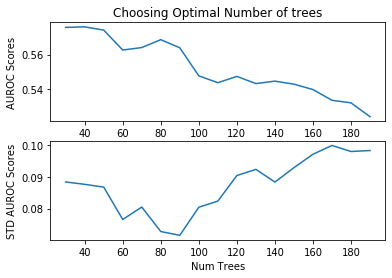

In [42]:
# 1. grid search on the n_estimators 

# as the number of trees increase, the std deviation decreases and prevents 
# over fitting and the accuracy increases. The increase is highest when the tree 
# is set at around 80, and the deviation is smaller. 

param_grid = {'n_estimators':range(30,200,10)}
gsearch = GridSearchCV(estimator = RandomForestClassifier(random_state=10), 
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train,y_train_category[category])

mean_test_scores = gsearch.cv_results_['mean_test_score']
std_test_score = gsearch.cv_results_['std_test_score']
n_estimators = gsearch.cv_results_['param_n_estimators']

plt.subplot(211)
plt.plot(n_estimators, mean_test_scores, label='n_estimators')
plt.title("Choosing Optimal Number of trees")
plt.xlabel("Num Trees")
plt.ylabel("AUROC Scores")

plt.subplot(212)
plt.plot(n_estimators, std_test_score, label='n_estimators')
plt.xlabel("Num Trees")
plt.ylabel("STD AUROC Scores")
plt.show()


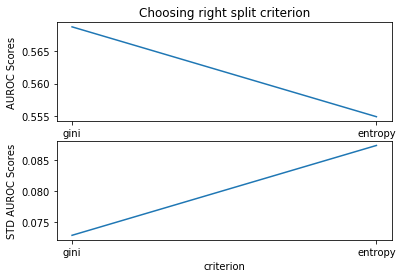

In [43]:
# 2. tune criterion 

# two different split criterion 

param_grid={'n_estimators':[80], 'criterion':['gini', 'entropy']}

gsearch= GridSearchCV(estimator = RandomForestClassifier(random_state=10), 
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train,y_train_category[category])

#for i in ['mean_test_score', 'std_test_score', 'param_n_estimators']:
#        print(i," : ",gsearch.cv_results_[i])
        

mean_test_scores = gsearch.cv_results_['mean_test_score']
std_test_score = gsearch.cv_results_['std_test_score']
criterion = gsearch.cv_results_['param_criterion']

plt.subplot(211)
plt.plot(criterion, mean_test_scores, label='criterion')
plt.title("Choosing right split criterion")
plt.xlabel("criterion")
plt.ylabel("AUROC Scores")

plt.subplot(212)
plt.plot(criterion, std_test_score, label='criterion')
plt.xlabel("criterion")
plt.ylabel("STD AUROC Scores")
plt.show()


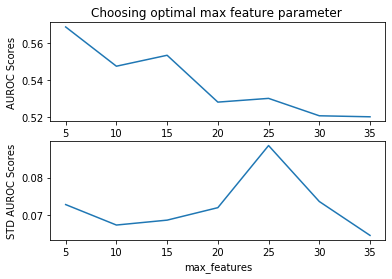

In [44]:
# 3. tune max_features
# default is auto，sqrt(68)= 8.24 
# setting this too small has led to inaccuracy in the base model and leads
# to decreased accuracy in the main model 

param_grid={'n_estimators':[80],'criterion':['gini'], 
            'max_features':np.arange(5, 50, 5)}


gsearch= GridSearchCV(estimator = RandomForestClassifier(random_state=10), 
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train,y_train_category[category])


mean_test_scores = gsearch.cv_results_['mean_test_score']
std_test_score = gsearch.cv_results_['std_test_score']
max_features = gsearch.cv_results_['param_max_features']
 
plt.subplot(211)
plt.plot(max_features, mean_test_scores)
plt.title("Choosing optimal max feature parameter ")
plt.xlabel("max_features")
plt.ylabel("AUROC Scores")

plt.subplot(212)
plt.plot(max_features, std_test_score)
plt.xlabel("max_features")
plt.ylabel("STD AUROC Scores")
plt.show()     

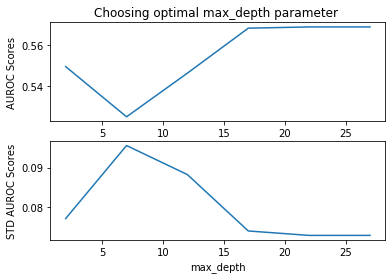

In [45]:
# 4. tune max_depth parameter

# in general, as tree depth increases, less bias in the base model 
# and better performance for the random forest model 

# However, if we adjust the depth parameter at the small scale, the performance
# is uncertain, i.e. it could go both ways
# if one less depth means smaller variance, then the performance of the 
# base model would improve; if one less depth means high bias, then
# the performace of the model would deteriote. 
# therefore, it's better to tune the parameter at larger intervals

param_grid={'n_estimators':[80],'criterion':['gini'],
            'max_depth':np.arange(2, 30, 5)}


gsearch= GridSearchCV(estimator = RandomForestClassifier(random_state=10), 
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train,y_train_category[category])


mean_test_scores = gsearch.cv_results_['mean_test_score']
std_test_score = gsearch.cv_results_['std_test_score']
max_depth = gsearch.cv_results_['param_max_depth']
 
plt.subplot(211)
plt.plot(max_depth, mean_test_scores)
plt.title("Choosing optimal max_depth parameter ")
plt.xlabel("max_depth")
plt.ylabel("AUROC Scores")

plt.subplot(212)
plt.plot(max_depth, std_test_score)
plt.xlabel("max_depth")
plt.ylabel("STD AUROC Scores")
plt.show()     

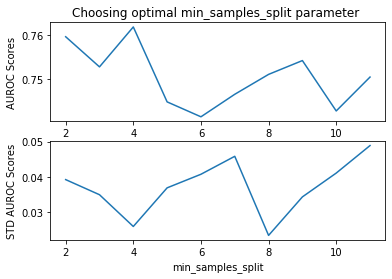

In [17]:
# 5. tune min_samples_split

# as the min sample split parameter increases, the base tree model becomes 
# simpler. theoretically, this leads to shallower trees and 
# more bias and smaller variance. looking at the training results
# the increase in performance due to smaller variance is
# best around 8

param_grid={'n_estimators':[80],'criterion':['gini'],
            'min_samples_split':np.arange(2, 2+10, 1)}

gsearch= GridSearchCV(estimator = RandomForestClassifier(random_state=10), 
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train,y_train_category[category])


mean_test_scores = gsearch.cv_results_['mean_test_score']
std_test_score = gsearch.cv_results_['std_test_score']
min_samples_split = gsearch.cv_results_['param_min_samples_split']
 
plt.subplot(211)
plt.plot(min_samples_split, mean_test_scores)
plt.title("Choosing optimal min_samples_split parameter ")
plt.xlabel("min_samples_split")
plt.ylabel("AUROC Scores")

plt.subplot(212)
plt.plot(min_samples_split, std_test_score)
plt.xlabel("min_samples_split")
plt.ylabel("STD AUROC Scores")
plt.show()     


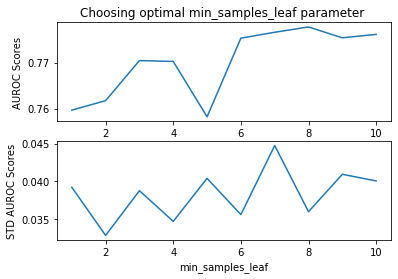

In [18]:
# 6. tune min_samples_leaf

# as the min sample split parameter increases, the base tree model becomes 
# simpler. theoretically, this leads to shallower trees and 
# more bias and smaller variance. looking at the training results
# the increase in performance due to smaller variance is

param_grid={'n_estimators':[80],'criterion':['gini'], 
            'min_samples_leaf':np.arange(1, 1+10, 1)}

gsearch= GridSearchCV(estimator = RandomForestClassifier(random_state=10), 
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train,y_train_category[category])


mean_test_scores = gsearch.cv_results_['mean_test_score']
std_test_score = gsearch.cv_results_['std_test_score']
min_samples_leaf = gsearch.cv_results_['param_min_samples_leaf']
 
plt.subplot(211)
plt.plot(min_samples_leaf, mean_test_scores)
plt.title("Choosing optimal min_samples_leaf parameter ")
plt.xlabel("min_samples_split")
plt.ylabel("AUROC Scores")

plt.subplot(212)
plt.plot(min_samples_leaf, std_test_score)
plt.xlabel("min_samples_leaf")
plt.ylabel("STD AUROC Scores")
plt.show()     


#### 2.3.2. Parameter tune on Gradient Boosting model

General hyperparameter tuning guidelines for Gradient Boosting

reference:

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

requires more n_estimators, and prefer weak learners (default max_depth =3) 

set initial values of parameters 

max_depth = 5 

min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.

gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.

subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.

scale_pos_weight = 1: Because of high class imbalance.

1.	Determine the objective hyperparameters (logistic vs multi-class)

2. tune Parameters such as Max_features, subsample ( decorrelate doesn’t help much)


3.	Tune the parameters that affect the Training process: n_estimators and learning rate (most important for boosting, and needs to tune together)

4.	Parameters that affect base learners: max_depth, criterion (set as small) 

    generally, in terms of importance:

    max_leaf_nodes and max_depth > （min_samples_split）+min_samples_leaf min_weight_fraction_leaf > max_features

    in class imbalance, low depth may overfit on the positive cases already and tuning would not make much difference. So need to tune in the order of min_samples_leaf, min_samples_split before you tune max_depth 

In [46]:
# Mannually iterate on the following choices of country,measure,category
# and document the optimal hyperparamters grid for both methods

# country,df = "MW",mw_village
# country,df = "TZ",tz_village
country,df = "UG",ug_village

measure = 'FCS'
# measure = 'rCSI'

# category = measure+'_binary_'+'safe'
# category = measure+'_binary_'+'bad'
category = measure+'_20_'+'bad'

df_test,df_train = year_split(country, df)
X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)


In [56]:
# Take notes of the following tuning results on gradient boosting 

######################################################
# most food secure VS rest (gradient boosting )
######################################################

MW_FCS_binary_safe_gb ={'n_estimators':[60],'learning_rate':[0.025],
'subsample':[0.88], 'max_features':[10],'min_samples_leaf':[90]}

MW_rCSI_binary_safe_gb ={'n_estimators':[70],'learning_rate':[0.1],
'subsample':[0.83], 'max_features':['auto'],'min_samples_leaf':[220]}

TZ_FCS_binary_safe_gb ={'n_estimators':[60],'learning_rate':[0.025],
            'subsample':[0.88], 'max_features':[12],'max_depth':[2] }

TZ_rCSI_binary_safe_gb ={'n_estimators':[55],'learning_rate':[0.050],
'subsample':[0.78], 'max_features':[16],'min_samples_leaf':[100]}

    
UG_FCS_binary_safe_gb ={'n_estimators':[60],'learning_rate':[0.050],
'subsample':[0.88], 'max_features':[11],'min_samples_leaf':[80]}
 
######################################################    
# most food insecure VS rest (gradient boosting )
######################################################

MW_FCS_binary_bad_gb ={'n_estimators':[80],'learning_rate':[0.06],
'subsample':[0.82], 'max_features':[11],'min_samples_leaf':[160]}
       
MW_rCSI_binary_bad_gb ={'n_estimators':[70],'learning_rate':[0.15],
'subsample':[0.78]}

TZ_FCS_binary_bad_gb ={'n_estimators':[70], 
             'learning_rate':[0.13],
            'subsample':[0.73], 'max_features':[11],
 'min_samples_split':[120],'max_depth':[3]}

TZ_rCSI_binary_bad_gb ={'n_estimators':[90],'learning_rate':[0.11],
            'subsample':[0.9], 'max_features':[7],
 'min_samples_split':[160],'max_depth':[3]}

UG_FCS_binary_bad_gb ={'n_estimators':[80],'learning_rate':[0.06],
'subsample':[0.78], 'max_features':[7],'max_depth':[4]}

 
######################################################  
# 20 percent (gradient boosting )
######################################################

MW_FCS_20_bad_gb ={'n_estimators':[80],
                'subsample':[0.78], 'max_features':[11],
          'min_samples_split':[160],'max_depth':[3]}

MW_rCSI_20_bad_gb ={'n_estimators':[60],'learning_rate':[0.03],
            'subsample':[0.92], 'max_features':[9],
          'min_samples_leaf':[50],'max_depth':[5]}

TZ_FCS_20_bad_gb ={'n_estimators':[80],'learning_rate':[0.11],
'subsample':[0.8], 'max_features':[8],'min_samples_split':[50],
                      'max_depth':[4]}

TZ_rCSI_20_bad_gb ={'n_estimators':[100],'learning_rate':[0.18],
            'subsample':[0.77], 'max_features':[11],
          'min_samples_split':[300],'max_depth':[3]}
                
UG_FCS_20_bad_gb ={'n_estimators':[150],'learning_rate':[0.25],
            'subsample':[0.77], 'max_features':[12],
          'min_samples_split':[40],'max_depth':[4]}


In [ ]:
UG_FCS_20_bad_gb ={'criterion':['mse'],'n_estimators':[60],'learning_rate':[0.25],
            'subsample':[0.90], 'max_features':[9],
          'min_samples_split':[140],'max_depth':[3]}

In [47]:
# 1. tune criterion 
# (keep default of friendman_mse

param_grid = {'n_estimators':[60], 'learning_rate':[0.1],
              'criterion': ['friedman_mse', 'mse', 'mae'],            
             }

gsearch= GridSearchCV(estimator = GradientBoostingClassifier( 
                           random_state=10),                      
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train,y_train_category[category])


for i in ['mean_test_score', 'std_test_score', 'param_criterion']:
        print(i," : ",gsearch.cv_results_[i])

mean_test_score  :  [0.52828446 0.53017993 0.50143304]
std_test_score  :  [0.08088887 0.07989644 0.03866163]
param_criterion  :  ['friedman_mse' 'mse' 'mae']


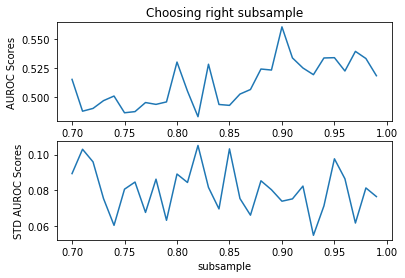

In [49]:
# 2. tune subsample 

param_grid={'criterion':['mse'],'n_estimators':[60], 'learning_rate':[0.1],
            'subsample':np.arange(0.7, 0.7+0.29, 0.01)}

gsearch= GridSearchCV(estimator = GradientBoostingClassifier( 
                           random_state=10),                      
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train,y_train_category[category])

#for i in ['mean_test_score', 'std_test_score', 'param_n_estimators']:
#        print(i," : ",gsearch.cv_results_[i])
        

mean_test_scores = gsearch.cv_results_['mean_test_score']
std_test_score = gsearch.cv_results_['std_test_score']
subsample = gsearch.cv_results_['param_subsample']

plt.subplot(211)
plt.plot(subsample, mean_test_scores, label='subsample')
plt.title("Choosing right subsample")
plt.xlabel("subsample")
plt.ylabel("AUROC Scores")

plt.subplot(212)
plt.plot(subsample, std_test_score, label='subsample')
plt.xlabel("subsample")
plt.ylabel("STD AUROC Scores")
plt.show()

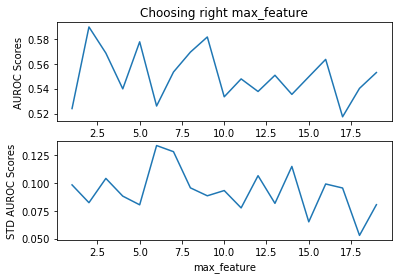

In [50]:
# 3. tune subsample and max_feature 

param_grid={'criterion':['mse'],'n_estimators':[60], 'learning_rate':[0.1], 
            'subsample':[0.90], 'max_features':np.arange(1, 1+19, 1)}
gsearch= GridSearchCV(estimator = GradientBoostingClassifier( 
                           random_state=10),                      
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train,y_train_category[category])

#for i in ['mean_test_score', 'std_test_score', 'param_n_estimators']:
#        print(i," : ",gsearch.cv_results_[i])
        

mean_test_scores = gsearch.cv_results_['mean_test_score']
std_test_score = gsearch.cv_results_['std_test_score']
max_feature = gsearch.cv_results_['param_max_features']

plt.subplot(211)
plt.plot(max_feature, mean_test_scores, label='max_feature')
plt.title("Choosing right max_feature")
plt.xlabel("max_feature")
plt.ylabel("AUROC Scores")

plt.subplot(212)
plt.plot(max_feature, std_test_score, label='max_feature')
plt.xlabel("max_feature")
plt.ylabel("STD AUROC Scores")
plt.show()

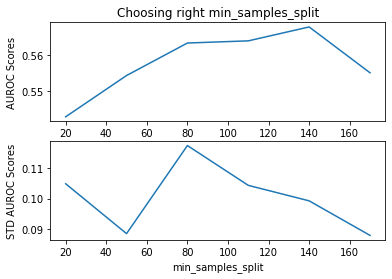

In [51]:
# 4. tune min_samples_leaf, min_samples_split 
# before you tune max_depth

# if tilting, keep at default

#param_grid={'n_estimators':[60], 'learning_rate':[0.1],
# 'min_samples_split':np.arange(2, 2+3000, 100)}

param_grid={'criterion':['mse'],'n_estimators':[60], 'learning_rate':[0.1],
            'subsample':[0.90], 'max_features':[9],
 'min_samples_split':np.arange(20, 200, 30)}
            
gsearch= GridSearchCV(estimator = GradientBoostingClassifier( 
                           random_state=10),                      
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train,y_train_category[category])

#for i in ['mean_test_score', 'std_test_score', 'param_n_estimators']:
#        print(i," : ",gsearch.cv_results_[i])
        

mean_test_scores = gsearch.cv_results_['mean_test_score']
std_test_score = gsearch.cv_results_['std_test_score']
min_samples_split = gsearch.cv_results_['param_min_samples_split']

plt.subplot(211)
plt.plot(min_samples_split, mean_test_scores, label='min_samples_split')
plt.title("Choosing right min_samples_split")
plt.xlabel("min_samples_split")
plt.ylabel("AUROC Scores")

plt.subplot(212)
plt.plot(min_samples_split, std_test_score, label='min_samples_split')
plt.xlabel("min_samples_split")
plt.ylabel("STD AUROC Scores")
plt.show()

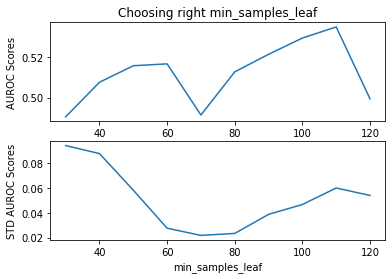

In [52]:
# 5. tune min_samples_leaf

param_grid={'n_estimators':[60], 'learning_rate':[0.1],
            'subsample':[0.9], 'max_features':[9],
 'min_samples_leaf':np.arange(30, 2+125, 10)}

gsearch= GridSearchCV(estimator = GradientBoostingClassifier( 
                           random_state=10),                      
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train,y_train_category[category])

#for i in ['mean_test_score', 'std_test_score', 'param_n_estimators']:
#        print(i," : ",gsearch.cv_results_[i])
        

mean_test_scores = gsearch.cv_results_['mean_test_score']
std_test_score = gsearch.cv_results_['std_test_score']
min_samples_leaf = gsearch.cv_results_['param_min_samples_leaf']

plt.subplot(211)
plt.plot(min_samples_leaf, mean_test_scores, label='min_samples_split')
plt.title("Choosing right min_samples_leaf")
plt.xlabel("min_samples_leaf")
plt.ylabel("AUROC Scores")

plt.subplot(212)
plt.plot(min_samples_leaf, std_test_score, label='min_samples_split')
plt.xlabel("min_samples_leaf")
plt.ylabel("STD AUROC Scores")
plt.show()

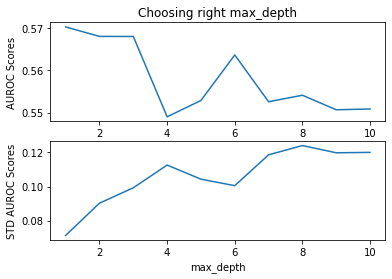

In [53]:
# 6. tune max_depth
# sometimes it's fixed after min_sample_leafs are tuned
# compare min_sample_split and min_sample_leafs's impact on performance
# before choosing which one to fix 

param_grid={'n_estimators':[60], 'learning_rate':[0.1],
            'subsample':[0.90], 'max_features':[9],
     'min_samples_split':[140],
  'max_depth':np.arange(1, 1+10, 1)}

gsearch= GridSearchCV(estimator = GradientBoostingClassifier( 
                           random_state=10),                      
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train,y_train_category[category])

#for i in ['mean_test_score', 'std_test_score', 'param_n_estimators']:
#        print(i," : ",gsearch.cv_results_[i])
        

mean_test_scores = gsearch.cv_results_['mean_test_score']
std_test_score = gsearch.cv_results_['std_test_score']
max_depth = gsearch.cv_results_['param_max_depth']

plt.subplot(211)
plt.plot(max_depth, mean_test_scores, label='max_depth')
plt.title("Choosing right max_depth")
plt.xlabel("max_depth")
plt.ylabel("AUROC Scores")

plt.subplot(212)
plt.plot(max_depth, std_test_score, label='max_depth')
plt.xlabel("max_depth")
plt.ylabel("STD AUROC Scores")

plt.show()

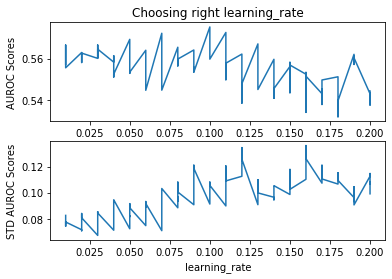

In [54]:
# 7. tune n_estimator and learning rate together 

param_grid={'n_estimators':np.arange(50, 50+50, 10), 
     'learning_rate':np.arange(0.01, 0.01+0.2, 0.01),
            'subsample':[0.90], 'max_features':[9],
          'min_samples_split':[140],'max_depth':[3]}

gsearch= GridSearchCV(estimator = GradientBoostingClassifier( 
                           random_state=10),                      
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train,y_train_category[category])

#for i in ['mean_test_score', 'std_test_score', 'param_n_estimators']:
#        print(i," : ",gsearch.cv_results_[i])
        

mean_test_scores = gsearch.cv_results_['mean_test_score']
std_test_score = gsearch.cv_results_['std_test_score']
learning_rate = gsearch.cv_results_['param_learning_rate']

plt.subplot(211)
plt.plot(learning_rate, mean_test_scores, label='learning_rate')
plt.title("Choosing right learning_rate")
plt.xlabel("learning_rate")
plt.ylabel("AUROC Scores")

plt.subplot(212)
plt.plot(learning_rate, std_test_score, label='learning_rate')
plt.xlabel("learning_rate")
plt.ylabel("STD AUROC Scores")
plt.show()

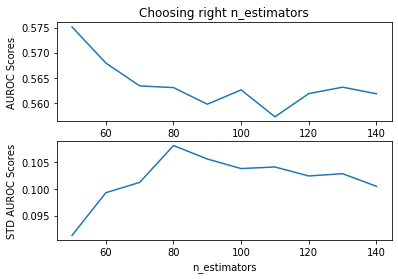

In [55]:
# 7. tune n_estimator and learning rate together 

param_grid={'n_estimators':np.arange(50, 50+100, 10), 
     #'learning_rate':np.arange(0.01, 0.01+0.2, 0.01),
            'learning_rate':[0.1],
            'subsample':[0.90], 'max_features':[9],
          'min_samples_split':[140],'max_depth':[3]}

gsearch= GridSearchCV(estimator = GradientBoostingClassifier( 
                           random_state=10),                      
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train,y_train_category[category])

#for i in ['mean_test_score', 'std_test_score', 'param_n_estimators']:
#        print(i," : ",gsearch.cv_results_[i])
        

mean_test_scores = gsearch.cv_results_['mean_test_score']
std_test_score = gsearch.cv_results_['std_test_score']
n_estimators = gsearch.cv_results_['param_n_estimators']

plt.subplot(211)
plt.plot(n_estimators, mean_test_scores, label='n_estimators')
plt.title("Choosing right n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("AUROC Scores")

plt.subplot(212)
plt.plot(n_estimators, std_test_score, label='n_estimators')
plt.xlabel("n_estimators")
plt.ylabel("STD AUROC Scores")
plt.show()

#### 2.3.3. Parameter tune on baseline logistic regression model

In [29]:
# Take notes of the following tuning results on logistic regression

######################################################
# most food secure VS rest (logistic regression)
######################################################

MW_FCS_binary_safe_lr ={'penalty':['l1'],'class_weight':['balanced'],'C':[10]}

MW_rCSI_binary_safe_lr ={'penalty':['l1'],'class_weight':[{0: 1, 1: 1000}],'C':[0.0001]}

TZ_FCS_binary_safe_lr ={'penalty':['l1'],'class_weight':['balanced'],'C':[0.1] }

TZ_rCSI_binary_safe_lr ={'penalty':['l1'],'class_weight':['balanced'],'C':[1]}

UG_FCS_binary_safe_lr ={'penalty':['l2'],'class_weight':[None],'C':[0.1]}
 
######################################################    
# most food insecure VS rest (logistic regression)
######################################################

MW_FCS_binary_bad_lr ={'penalty':['l2'],'class_weight':[{0: 2, 1: 8}],'C':[100]}
       
MW_rCSI_binary_bad_lr ={'penalty':['l2'],'class_weight':['balanced'],'C':[1]}

TZ_FCS_binary_bad_lr ={'penalty':['l1'],'class_weight':['balanced'],'C':[0.0001]}

TZ_rCSI_binary_bad_lr ={'penalty':['l1'],'class_weight':['balanced'],'C':[10]}

UG_FCS_binary_bad_lr ={'penalty':['l1'],'class_weight':[{0: 2, 1: 8}],'C':[10]}

 
######################################################  
# 20 percent (logistic regression)
######################################################

MW_FCS_20_bad_lr ={'penalty':['l1'],'class_weight':[{0: 2, 1: 8}],'C':[10]}

MW_rCSI_20_bad_lr ={'penalty':['l1'],'class_weight':[None],'C':[0.1]}

TZ_FCS_20_bad_lr ={'penalty':['l1'],'class_weight':['balanced'],'C':[1]}

TZ_rCSI_20_bad_lr ={'penalty':['l1'],'class_weight':['balanced'],'C':[10]}
                
UG_FCS_20_bad_lr ={'penalty':['l2'],'class_weight':['balanced'],'C':[1]}



In [30]:
# Mannually iterate on the following choices of country,measure,category
# and document the optimal hyperparamters grid for both methods

# country,df = "MW",mw_village
# country,df = "TZ",tz_village
country,df = "UG",ug_village

measure = 'FCS'
# measure = 'rCSI'

# category = measure+'_binary_'+'safe'
# category = measure+'_binary_'+'bad'
category = measure+'_20_'+'bad'

df_test,df_train = year_split(country, df)
X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)



In [31]:
# 0. tune class weights

param_grid = {'class_weight': [{0: 1, 1: 1000},{0: 1, 1: 100},{0: 1, 1: 10},{0: 2, 1: 8},'balanced',None],            
             }

gsearch= GridSearchCV(estimator = LogisticRegression( 
                           random_state=10),                      
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train,y_train_category[category])

for i in ['mean_test_score', 'std_test_score', 'param_class_weight']:
        print(i," : ",gsearch.cv_results_[i])
        


mean_test_score  :  [0.51022032 0.53217475 0.55391227 0.58654195 0.60209917 0.55666792]
std_test_score  :  [0.04116582 0.0205369  0.05285187 0.05883369 0.06734816 0.03757691]
param_class_weight  :  [{0: 1, 1: 1000} {0: 1, 1: 100} {0: 1, 1: 10} {0: 2, 1: 8} 'balanced' None]


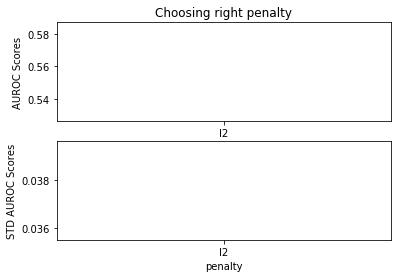

In [32]:
# 1. tune penalty

param_grid={'penalty':['l1','l2']}

gsearch= GridSearchCV(estimator = LogisticRegression( 
                           random_state=10),                      
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train,y_train_category[category])

#for i in ['mean_test_score', 'std_test_score', 'param_n_estimators']:
#        print(i," : ",gsearch.cv_results_[i])
        

mean_test_scores = gsearch.cv_results_['mean_test_score']
std_test_score = gsearch.cv_results_['std_test_score']
penalty = gsearch.cv_results_['param_penalty']

plt.subplot(211)
plt.plot(penalty, mean_test_scores, label='penalty')
plt.title("Choosing right penalty")
plt.xlabel("penalty")
plt.ylabel("AUROC Scores")

plt.subplot(212)
plt.plot(penalty, std_test_score, label='penalty')
plt.xlabel("penalty")
plt.ylabel("STD AUROC Scores")
plt.show()

In [33]:
# 2. tune regularization parameter C : smaller values are higher penalties 

param_grid={'C':[0.0001, 0.1,1,10, 100]}

gsearch= GridSearchCV(estimator = LogisticRegression( 
                           random_state=10),                      
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train,y_train_category[category])

for i in ['mean_test_score', 'std_test_score', 'param_C']:
        print(i," : ",gsearch.cv_results_[i])
        

mean_test_score  :  [0.5265666  0.59265577 0.55666792 0.59826427 0.56158135]
std_test_score  :  [0.07430974 0.0363408  0.03757691 0.02521481 0.03662261]
param_C  :  [0.0001 0.1 1 10 100]


### Upsample for the Food insecure category

In [57]:
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler 
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN

def upsample_minority(X_train,y_train):
        
    ros = RandomOverSampler(random_state=42,sampling_strategy='minority')
    X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
    
    return X_train_ros, y_train_ros
   

def smote_minority(X_train,y_train):
    
    smt = SMOTETomek(random_state=42,sampling_strategy='minority')

    X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train)
    
    return X_train_smote, y_train_smote 

def adasyn_minority(X_train,y_train):
    
    ada = ADASYN(random_state=42,n_jobs=5,sampling_strategy='minority')

    X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)
    
    return X_train_ada, y_train_ada 

def upsample_training_set(country,df,measure,cut):
      
    df_test,df_train = year_split(country, df)
    
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    
    category = measure + cut

    y_test = y_test_category[category]
    
    # Upsample 
    X_train_upsampled,y_train_upsampled = upsample_minority(X_train,y_train_category[category])
    
    # error handling of cases where there's not enough minority cases 
    
    # SMOTE 
    try:
        X_train_smote,y_train_smote = smote_minority(X_train,y_train_category[category])
    except:
        X_train_upsampled,y_train_upsampled = upsample_minority(X_train,y_train_category[category])
        X_train_smote,y_train_smote = smote_minority(X_train_upsampled,y_train_upsampled)
    
    # ADASYN
    try:
        X_train_adasyn,y_train_adasyn = adasyn_minority(X_train,y_train_category[category])
    except:
        X_train_upsampled,y_train_upsampled = upsample_minority(X_train,y_train_category[category])
        X_train_adasyn,y_train_adasyn = adasyn_minority(X_train_upsampled,y_train_upsampled)

    return X_train,y_train_category[category],X_train_upsampled,y_train_upsampled,X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test

In [ ]:

MW_FCS_rf_upsample = {'class_weight':['balanced_subsample'],
'n_estimators':[170],'criterion':['gini'],'max_features':[15],
'max_depth':[5],'min_samples_split':[5],'min_samples_leaf':[9]}

MW_FCS_rf_smote = {'class_weight':['balanced_subsample'],
'n_estimators':[170],'criterion':['gini'],'max_features':[15],
'max_depth':[5],'min_samples_split':[5],'min_samples_leaf':[9]}

MW_FCS_rf_adasyn = {'class_weight':['balanced_subsample'],
'n_estimators':[170],'criterion':['gini'],'max_features':[15],
'max_depth':[5],'min_samples_split':[5],'min_samples_leaf':[9]}


MW_rCSI_rf_upsample={'class_weight':['balanced_subsample'],
'n_estimators':[120],'criterion':['gini'],'max_features':[12],
'max_depth':[5],'min_samples_split':[8],'min_samples_leaf':[4]}

MW_rCSI_rf_smote={'class_weight':['balanced_subsample'],
'n_estimators':[120],'criterion':['gini'],'max_features':[12],
'max_depth':[5],'min_samples_split':[8],'min_samples_leaf':[4]}

MW_rCSI_rf_adasyn={'class_weight':['balanced_subsample'],
'n_estimators':[120],'criterion':['gini'],'max_features':[12],
'max_depth':[5],'min_samples_split':[8],'min_samples_leaf':[4]}


TZ_FCS_rf_upsample = {'class_weight':[{0: 2, 1: 8}],
'n_estimators':[80],'criterion':['gini'],'max_features':[20],
'max_depth':[10],'min_samples_split':[4],'min_samples_leaf':[10]}

TZ_FCS_rf_smote = {'class_weight':[{0: 2, 1: 8}],
'n_estimators':[80],'criterion':['gini'],'max_features':[20],
'max_depth':[10],'min_samples_split':[4],'min_samples_leaf':[10]}


TZ_FCS_rf_adasyn = {'class_weight':[{0: 2, 1: 8}],
'n_estimators':[80],'criterion':['gini'],'max_features':[20],
'max_depth':[10],'min_samples_split':[4],'min_samples_leaf':[10]}



TZ_rCSI_rf_upsample = {'class_weight':[{0: 1, 1: 100}],
'n_estimators':[80],'criterion':['entropy'],'max_features':[20],
'max_depth':[5],'min_samples_split':[6],'min_samples_leaf':[4]}

TZ_rCSI_rf_smote = {'class_weight':[{0: 1, 1: 100}],
'n_estimators':[80],'criterion':['entropy'],'max_features':[20],
'max_depth':[5],'min_samples_split':[6],'min_samples_leaf':[4]}

TZ_rCSI_rf_adasyn = {'class_weight':[{0: 1, 1: 100}],
'n_estimators':[80],'criterion':['entropy'],'max_features':[20],
'max_depth':[5],'min_samples_split':[6],'min_samples_leaf':[4]}



UG_FCS_rf_upsample= {'class_weight':[{0: 2, 1: 8}],
'n_estimators':[140],'criterion':['gini'],'max_features':[10],
'max_depth':[12],'min_samples_split':[7],'min_samples_leaf':[4]}

UG_FCS_rf_smote= {'class_weight':[{0: 1, 1: 1000}],
'n_estimators':[140],'criterion':['gini'],'max_features':[20],
'max_depth':[12],'min_samples_split':[7],'min_samples_leaf':[4]}

UG_FCS_rf_adasyn= {'class_weight':[{0: 1, 1: 1000}],
'n_estimators':[140],'criterion':['gini'],'max_features':[20],
'max_depth':[5],'min_samples_split':[7],'min_samples_leaf':[4]}

In [58]:
# Mannually iterate on the following choices of country,measure,category
# and document the optimal hyperparamters grid for both methods

# country,df = "MW",mw_village
# country,df = "TZ",tz_village
country,df = "UG",ug_village

measure = 'FCS'
# measure = 'rCSI'

cut='_20_'+'bad'


X_train,y_train,X_train_upsampled,y_train_upsampled,X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test=upsample_training_set(country,df,measure,cut)


In [ ]:
UG_FCS_rf_smote= {'class_weight':[{0: 1, 1: 1000}],
'n_estimators':[140],'criterion':['gini'],'max_features':[20],
'max_depth':[12],'min_samples_split':[7],'min_samples_leaf':[4]}


In [59]:
# 0. tune class weights

param_grid = {'class_weight': [{0: 1, 1: 1000},{0: 1, 1: 100},{0: 1, 1: 10},{0: 2, 1: 8},'balanced','balanced_subsample'],            
             }

gsearch= GridSearchCV(estimator = RandomForestClassifier(random_state=10), 
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train_smote,y_train_smote)


for i in ['mean_test_score', 'std_test_score', 'param_class_weight']:
        print(i," : ",gsearch.cv_results_[i])
        

mean_test_score  :  [0.76262095 0.75418335 0.74837754 0.73310394 0.70140557 0.71281698]
std_test_score  :  [0.16435866 0.17102206 0.18291328 0.18645057 0.186734   0.1879029 ]
param_class_weight  :  [{0: 1, 1: 1000} {0: 1, 1: 100} {0: 1, 1: 10} {0: 2, 1: 8} 'balanced'
 'balanced_subsample']


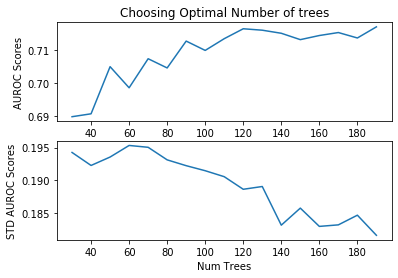

In [60]:
# 1. grid search on the n_estimators 

# as the number of trees increase, the std deviation decreases and prevents 
# over fitting and the accuracy increases. The increase is highest when the tree 
# is set at around 80, and the deviation is smaller. 

param_grid = {'n_estimators':range(30,200,10)}
gsearch = GridSearchCV(estimator = RandomForestClassifier(random_state=10), 
                       param_grid = param_grid, scoring='roc_auc',cv=5)

gsearch.fit(X_train_smote,y_train_smote)

mean_test_scores = gsearch.cv_results_['mean_test_score']
std_test_score = gsearch.cv_results_['std_test_score']
n_estimators = gsearch.cv_results_['param_n_estimators']

plt.subplot(211)
plt.plot(n_estimators, mean_test_scores, label='n_estimators')
plt.title("Choosing Optimal Number of trees")
plt.xlabel("Num Trees")
plt.ylabel("AUROC Scores")

plt.subplot(212)
plt.plot(n_estimators, std_test_score, label='n_estimators')
plt.xlabel("Num Trees")
plt.ylabel("STD AUROC Scores")
plt.show()


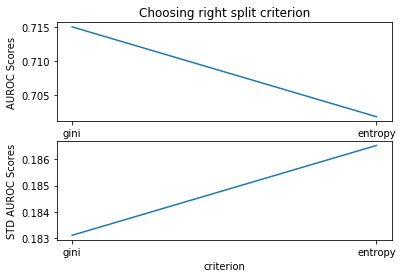

In [61]:
# 2. tune criterion 

# two different split criterion 

param_grid={'n_estimators':[140], 'criterion':['gini', 'entropy']}

gsearch= GridSearchCV(estimator = RandomForestClassifier(random_state=10), 
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train_smote,y_train_smote)

#for i in ['mean_test_score', 'std_test_score', 'param_n_estimators']:
#        print(i," : ",gsearch.cv_results_[i])
        

mean_test_scores = gsearch.cv_results_['mean_test_score']
std_test_score = gsearch.cv_results_['std_test_score']
criterion = gsearch.cv_results_['param_criterion']

plt.subplot(211)
plt.plot(criterion, mean_test_scores, label='criterion')
plt.title("Choosing right split criterion")
plt.xlabel("criterion")
plt.ylabel("AUROC Scores")

plt.subplot(212)
plt.plot(criterion, std_test_score, label='criterion')
plt.xlabel("criterion")
plt.ylabel("STD AUROC Scores")
plt.show()



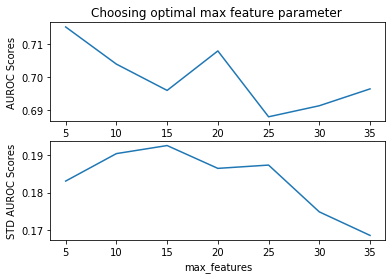

In [62]:
# 3. tune max_features
# default is auto，sqrt(68)= 8.24 
# setting this too small has led to inaccuracy in the base model and leads
# to decreased accuracy in the main model 

param_grid={'n_estimators':[140],'criterion':['gini'], 
            'max_features':np.arange(5, 50, 5)}


gsearch= GridSearchCV(estimator = RandomForestClassifier(random_state=10), 
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train_smote,y_train_smote)


mean_test_scores = gsearch.cv_results_['mean_test_score']
std_test_score = gsearch.cv_results_['std_test_score']
max_features = gsearch.cv_results_['param_max_features']
 
plt.subplot(211)
plt.plot(max_features, mean_test_scores)
plt.title("Choosing optimal max feature parameter ")
plt.xlabel("max_features")
plt.ylabel("AUROC Scores")

plt.subplot(212)
plt.plot(max_features, std_test_score)
plt.xlabel("max_features")
plt.ylabel("STD AUROC Scores")
plt.show()     

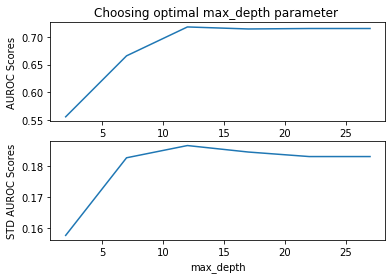

In [63]:
# 4. tune max_depth parameter

# in general, as tree depth increases, less bias in the base model 
# and better performance for the random forest model 

# However, if we adjust the depth parameter at the small scale, the performance
# is uncertain, i.e. it could go both ways
# if one less depth means smaller variance, then the performance of the 
# base model would improve; if one less depth means high bias, then
# the performace of the model would deteriote. 
# therefore, it's better to tune the parameter at larger intervals

param_grid={'n_estimators':[140],'criterion':['gini'],
            'max_depth':np.arange(2, 30, 5)}


gsearch= GridSearchCV(estimator = RandomForestClassifier(random_state=10), 
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train_smote,y_train_smote)


mean_test_scores = gsearch.cv_results_['mean_test_score']
std_test_score = gsearch.cv_results_['std_test_score']
max_depth = gsearch.cv_results_['param_max_depth']
 
plt.subplot(211)
plt.plot(max_depth, mean_test_scores)
plt.title("Choosing optimal max_depth parameter ")
plt.xlabel("max_depth")
plt.ylabel("AUROC Scores")

plt.subplot(212)
plt.plot(max_depth, std_test_score)
plt.xlabel("max_depth")
plt.ylabel("STD AUROC Scores")
plt.show()     

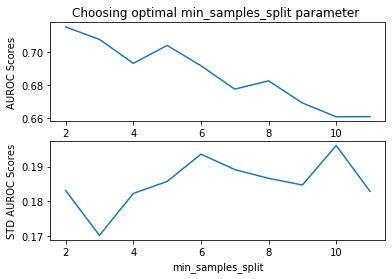

In [64]:
# 5. tune min_samples_split

# as the min sample split parameter increases, the base tree model becomes 
# simpler. theoretically, this leads to shallower trees and 
# more bias and smaller variance. looking at the training results
# the increase in performance due to smaller variance is
# best around 8

param_grid={'n_estimators':[140],'criterion':['gini'],
            'min_samples_split':np.arange(2, 2+10, 1)}

gsearch= GridSearchCV(estimator = RandomForestClassifier(random_state=10), 
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train_smote,y_train_smote)


mean_test_scores = gsearch.cv_results_['mean_test_score']
std_test_score = gsearch.cv_results_['std_test_score']
min_samples_split = gsearch.cv_results_['param_min_samples_split']
 
plt.subplot(211)
plt.plot(min_samples_split, mean_test_scores)
plt.title("Choosing optimal min_samples_split parameter ")
plt.xlabel("min_samples_split")
plt.ylabel("AUROC Scores")

plt.subplot(212)
plt.plot(min_samples_split, std_test_score)
plt.xlabel("min_samples_split")
plt.ylabel("STD AUROC Scores")
plt.show()     



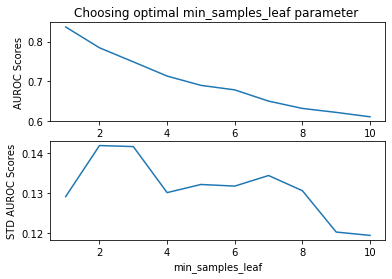

In [65]:
# 6. tune min_samples_leaf

# as the min sample split parameter increases, the base tree model becomes 
# simpler. theoretically, this leads to shallower trees and 
# more bias and smaller variance. looking at the training results
# the increase in performance due to smaller variance is

param_grid={'n_estimators':[140],'criterion':['gini'], 
            'min_samples_leaf':np.arange(1, 1+10, 1)}

gsearch= GridSearchCV(estimator = RandomForestClassifier(random_state=10), 
                       param_grid = param_grid, scoring='roc_auc',cv=5)
gsearch.fit(X_train_upsampled,y_train_upsampled)


mean_test_scores = gsearch.cv_results_['mean_test_score']
std_test_score = gsearch.cv_results_['std_test_score']
min_samples_leaf = gsearch.cv_results_['param_min_samples_leaf']
 
plt.subplot(211)
plt.plot(min_samples_leaf, mean_test_scores)
plt.title("Choosing optimal min_samples_leaf parameter ")
plt.xlabel("min_samples_split")
plt.ylabel("AUROC Scores")

plt.subplot(212)
plt.plot(min_samples_leaf, std_test_score)
plt.xlabel("min_samples_leaf")
plt.ylabel("STD AUROC Scores")
plt.show()     

